### STEP
First , install the required packages

In [ ]:
pip install -U langgraph langsmith 

### Initlization proxy config

In [ ]:
import os

# [Optinal] set proxy
proxy = os.getenv("PROXY_VALUE")

# 设置代理
for proxy_var in ['HTTP_PROXY', 'HTTPS_PROXY', 'http_proxy', 'https_proxy']:
    os.environ[proxy_var] = proxy

# load google access config file
credential_path="/Users/gongbiao/Code/vertex-ai/config/google_access_token_cp.json"
if os.path.exists(credential_path):
    print(f"the config load success")
else:
    print("config file does'not exists!")
    
# init vertex ai
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

the config load success


### Part1: Build a Basic Chatbot
We'll first create a simple chatbot using LangGraph. This chatbot will responsed directly to user messages. Though simple, it will 
illustrate the core concepts of building with LangGraph. By the end of this section, you will have a build rudimentary chatbot.

Start by createing a `StateGraph`. A `StateGraph` object defines the structure of our chatbot as a "state machine". We'll add nodes to represent the llm and functions our chatbot cancall and `edges` to specify how the bot should transition between these functions.

In [3]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    # Messages have the type "list". the `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends message to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]
    
graph_builder = StateGraph(State)


So now our graph knows two things:
1. Every `node` we define will receive the current `State` as input and return a value than updateds that state.
2. `messages` will be appended to the current list, rahter than directly overwritten. This is communicated via the prebuild 
`add_messages` functino in the `Anotated` syntax

Next, add a "chatbot" node. Nodes represent units of work. They are typically regualr python functions


In [4]:
from langchain_google_vertexai import ChatVertexAI
llm = ChatVertexAI(model_name="gemini-1.5-flash-002", temperature=0.2)

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

# The first argument is the unique node name
# the second argument is the function or object than will be called whenever
# the node is used

graph_builder.add_node("chatbot", chatbot)
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")
graph = graph_builder.compile()


### Or use second method add entry and finish point

Next, add an `entry` point. This tells our graph `where to start its work` each time we run it.

In [ ]:
graph_builder.add_edge(START, "chatbot")


Similarly, set a `finish` point. This instructs the graph `any time this node is run, you can exit.`

In [ ]:
graph_builder.add_edge("chatbot", END)

Finally, we'll want to be able to run our graph. To do so, call `compile()` on the graph builder. This creats a "CompiledGraph" 
we can use invoke on our state.

In [ ]:
graph = graph_builder.compile()

You can visualize the graph using the `get_graph` method and one of the "draw" methods, like `draw_ascii` or `dra_png`. the
`draw` methods each require additional dependencies.

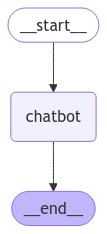

In [6]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print("Error displaying graph:", e)

### Now let's run the chatbot!

In [5]:
def steam_graph_updates(user_input: str):
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)
            
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["exit", "quit", "q"]:
            print("Goodbye!")
            break
        steam_graph_updates(user_input)
    except Exception as e:
        # fallback if input() is not available
        print("Error:", e)
        user_input = "What do you know about the universe?"
        print("User: " + user_input)
        steam_graph_updates(user_input)
        break

Assistant: 成都的咖啡店非常多，风格各异，要列举所有“有名”的不太现实，因为“有名”本身就比较主观。不过，我可以根据不同类型和特点，列举一些成都比较受欢迎和知名的咖啡店，供你参考：

**高颜值/网红店:**

* **方所:** 不仅仅是咖啡店，更是一个集合了书店、文创、展览等多种业态的文化空间，环境极佳，适合拍照打卡。
* **猫的天空之城概念书店:**  类似方所，也是集咖啡、书店、文创于一体，文艺气息浓厚，多家分店，各有特色。
* **一些独立咖啡店:** 成都许多独立咖啡店都非常注重装修和氛围，在小红书等平台上很受欢迎，但具体店名需要根据你的喜好（例如喜欢日式、欧式、工业风等等）来搜索。


**精品咖啡/手冲咖啡:**

* **许多独立咖啡店:**  成都的精品咖啡馆数量众多，很多都专注于手冲咖啡和单品咖啡豆，品质较高，但通常需要自己去寻找和发现。  这些店通常不会大肆宣传，需要通过口碑或咖啡爱好者社区了解。
* **一些连锁咖啡店的高端门店:**  例如一些连锁咖啡店会开设一些旗舰店或高端门店，提供更优质的咖啡和服务。


**特色咖啡店:**

* **结合其他业态的咖啡店:**  例如一些结合了烘焙、甜品、花艺等业态的咖啡店，会提供更丰富的体验。


**需要注意的是:**  成都的咖啡店市场变化很快，新店不断涌现，老店也可能调整或关闭。  建议你在去之前，通过大众点评、小红书等平台查看最新的评价和照片，选择最符合你口味和需求的咖啡店。


总而言之，要找到你心目中“有名”的咖啡店，最好根据你的喜好（例如咖啡豆种类、环境风格、价格区间等）进行更具体的搜索。  例如，你想找一家安静的手冲咖啡店，还是一家热闹的网红打卡店？  明确你的需求，才能找到最适合你的咖啡店。

Assistant: 成都被称为休闲城市，是多种因素共同作用的结果：

* **慢节奏的生活方式:** 成都人生活节奏相对较慢，不那么急功近利。这体现在人们的待人接物、工作方式和生活习惯上，更注重享受当下。  不像北上广深那样快节奏的生活，成都更强调“安逸”。

* **丰富的休闲娱乐活动:** 成都拥有众多茶馆、公园、酒吧、博物馆等休闲娱乐场所，为市民提供了丰富的选择。  人们可以悠闲地喝茶聊天、在公园散步、欣赏川剧变脸等，这些活动都营造了轻松休闲的氛围。

* **美食文

Retrying langchain_google_vertexai.chat_models._completion_with_retry.<locals>._completion_with_retry_inner in 4.0 seconds as it raised InvalidArgument: 400 Unable to submit request because it must include at least one parts field, which describes the prompt input. Learn more: https://cloud.google.com/vertex-ai/generative-ai/docs/model-reference/gemini.


KeyboardInterrupt: 